# Imports

In [1]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm                                    # For nice progress bar!

import torch
from torch import optim                                  # For optimizers like SGD, Adam, etc.
from torch import nn                                     # All neural network modules
from torch.utils.data import DataLoader                  # Gives easier dataset managment by creating mini batches etc.

import torchvision                                       # torch package for vision related things
from torchvision import transforms                       # Transformations we can perform on our dataset for augmentation

For much better performance we try to use the GPU

In [2]:
!nvidia-smi

Sat May 11 17:15:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX230           Off | 00000000:02:00.0 Off |                  N/A |
| N/A   73C    P0              N/A / ERR! |      3MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()
print(device)

cuda


# Setting some hyperparameters

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Hyperparameters
batch_size = 128 # batch size
lr = 4e-3 # learning rate
num_epochs = 10

in_channels = 3
dim = 32 #default cifar10 image size
num_classes = 10

# Loading the dataset

In [5]:
# Load Data
default_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=default_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=default_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def imshow(img):
    mean=[0.491, 0.482, 0.446]
    std=[0.247, 0.243, 0.261]
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

torch.Size([128, 3, 32, 32])


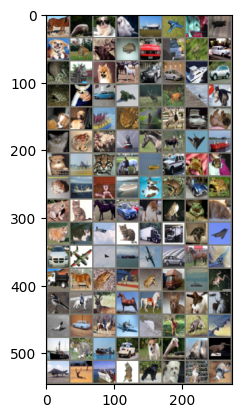

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter) # next batch size
print(images.shape)
imshow(torchvision.utils.make_grid(images[:batch_size]))

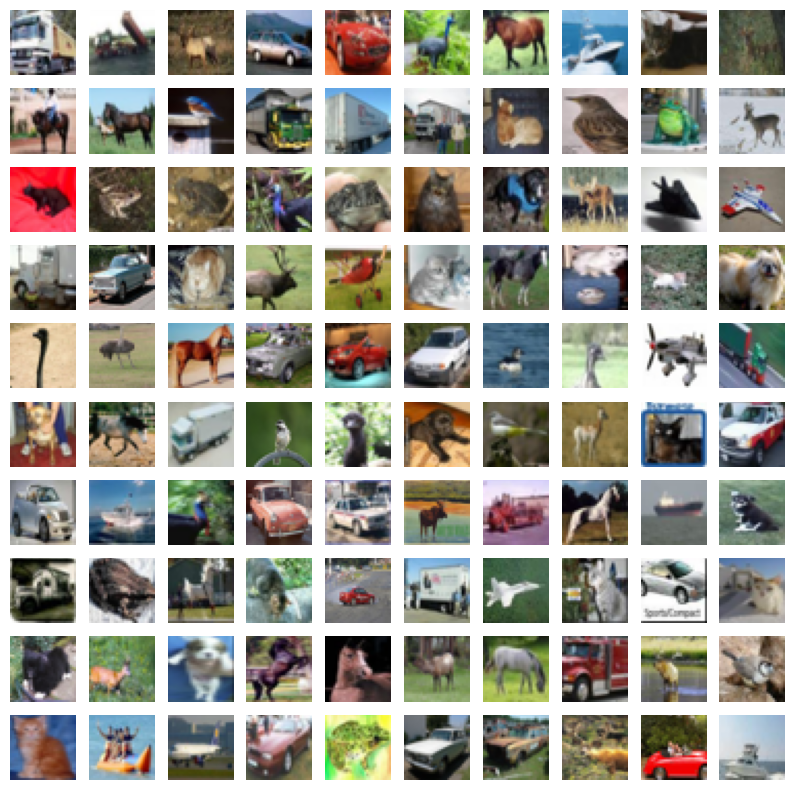

In [8]:
plt.figure(figsize=(10, 10))
for i in range(1, 101, 1):
  plt.subplot(10, 10, i)
  plt.imshow(trainset.data[i])
  plt.axis('off')
plt.show()

## Define the MobileNetV1 Model
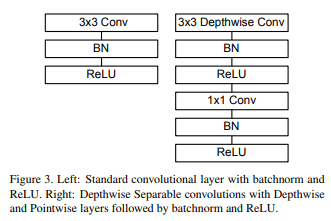

In [9]:
class Depth_Layer(nn.Module):
    # Depthwise convolution, currently slow to train in PyTorch
    def __init__(self, in_dim, out_dim, stride):
        super(Depth_Layer, self).__init__()
        self.dw_conv_k3 = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=stride, padding=1, groups=in_dim, bias=False)
        self.bn = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.dw_conv_k3(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    
class Point_Layer(nn.Module):
    # Pointwise 1 x 1 convolution
    def __init__(self, in_dim, out_dim):
        super(Point_Layer, self).__init__()
        self.p_conv_k1 = nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.p_conv_k1(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

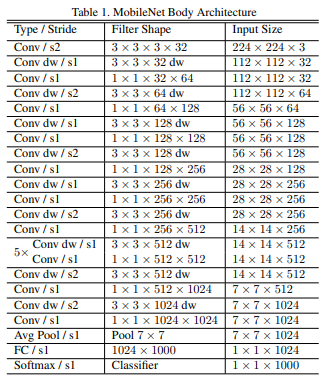

In [10]:
class MobileNetV1(nn.Module):

    def __init__(self, ch=3, n_classes=1000):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            Depth_Layer(32, 32, 1),
            Point_Layer(32, 64),
            Depth_Layer(64, 64, 2),
            Point_Layer(64, 128),
            Depth_Layer(128, 128, 1),
            Point_Layer(128, 128),
            Depth_Layer(128, 128, 2),
            Point_Layer(128, 256),
            Depth_Layer(256, 256, 1),
            Point_Layer(256, 256),
            Depth_Layer(256, 256, 2),
            Point_Layer(256, 512),
            Depth_Layer(512, 512, 1),
            Point_Layer(512, 512),
            Depth_Layer(512, 512, 1),
            Point_Layer(512, 512),
            Depth_Layer(512, 512, 1),
            Point_Layer(512, 512),
            Depth_Layer(512, 512, 1),
            Point_Layer(512, 512),
            Depth_Layer(512, 512, 1),
            Point_Layer(512, 512),
            Depth_Layer(512, 512, 2),
            Point_Layer(512, 1024),
            Depth_Layer(1024, 1024, 2),
            Point_Layer(1024, 1024),
            nn.AdaptiveAvgPool2d(1),
        )

        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [11]:
from torchsummary import summary

model = MobileNetV1(ch=3, n_classes=1000).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
       Depth_Layer-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           2,048
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
      Point_Layer-11         [-1, 64, 112, 112]               0
           Conv2d-12           [-1, 64, 56, 56]             576
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Train Loop

In [12]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_index, (images, targets) in loop:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss =  criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # progress bar information updating
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]" + f" Loss: {loss.item():.4f}")

  0%|          | 0/391 [00:00<?, ?it/s]/home/bogdan/.anaconda3/envs/pytorch_cuda_env/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


# Getting the accuracy of model on train and test splits

In [13]:
# get accuracy on training & test to see how good our model is
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            logits = model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [14]:
print(f"Accuracy on training set: {get_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 84.29
Accuracy on test set: 72.62


# Sample Test

In [15]:
def imshow_with_labels(ax, img, true_label, pred_label):
    mean=[0.491, 0.482, 0.446]
    std=[0.247, 0.243, 0.261]
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'{true_label.upper()} --> {pred_label}')
    ax.axis('off')

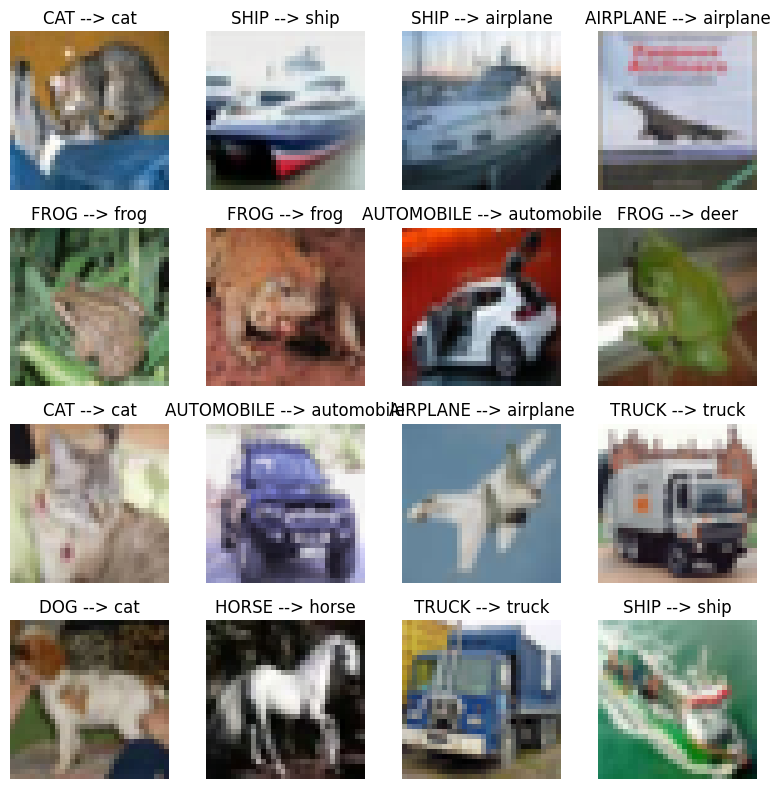

In [17]:
from math import sqrt

sample_size = 16
dataiter = iter(test_loader)
images, labels = next(dataiter)

x = images.to(device=device)
y = labels.to(device=device)
logits = model(x)
_, predictions = logits.max(1)

true_labels = [classes[label] for label in labels[:sample_size]]
pred_labels = [classes[label] for label in predictions[:sample_size]]

fig, axes = plt.subplots(int(sqrt(sample_size)), int(sqrt(sample_size)), figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    imshow_with_labels(ax, images[i], true_labels[i], pred_labels[i])
plt.tight_layout()
plt.show()